# Restricted Boltzmann Machines
This notebook is based on http://cms.dm.uba.ar/academico/materias/1ercuat2018/probabilidades_y_estadistica_C/5a89b5075af5cbef5becaf419457cdd77cc9.pdf and on https://arxiv.org/pdf/1810.11503.pd. The solutions to the exercises proposed in the first part of the notebook can be found in the first paper.

## General framework

In this notebook we will build a generative model known as Restricted Boltzmann Machines, and we will train it for the 1-dimensional Ising model. An RBM consists of $m$ visible nodes $v_j,\,\,j= 1,..,m $ (collectively denoted as $\bf{v}$) and $n$ hidden nodes $h_i,\,\,i= 1,..,n $ (collectively denoted as $\bf{}h$). We will consider the case of binary variables, namely $v_j, h_i \in \{0,1\}$.

We can define an energy function 
$$
E\left(\bf{v},\bf{h}\,|\,\theta\right) = -\sum_{i,j}w_{ij}h_iv_j - \sum_j b_j h_j - \sum_i c_i v_i\,,
$$
where $w_{ij}, b_j, c_i$ are free parameters denoted collectively as $\theta$.

The joint conditional probability of the state $\{\bf{v},\bf{h}\}$ given the set of free parameters $\theta$ is then defined as
$
p\left(\bf{v},\bf{h}\,|\,\theta\right) = e^{-E\left(\bf{v},\bf{h}\,|\,\theta\right)}/Z\left(\theta\right)\,\
$
with $Z\left(\theta\right)=\sum_{\bf{v},\bf{h}} p\left(\bf{v},\bf{h}\,|\,\theta\right)$.
Upon marginalization over the hidden variables $\bf{h}$, we get the probability distribution of the variables in the visible layer in terms of the free parameters of our model

$$p\left(\bf{v}\,|\,\theta\right) = \sum_{\bf{h}} p\left(\bf{v},\bf{h}\,|\,\theta\right).$$

Each visible variable $\bf{v}$ can then be identified as a state of some physical system, and the machine can be trained in order to learn the corresponding underlying distribution. In this notebook we will train the RBM on a set of Ising spins in 1 dimension.

In order to train the RBM the training set is partitioned into batches $S$ and the log-likelihood is maximized as a function of the free parameters of the model

$$
\log\mathcal{L}\left(\theta\right) = \sum_{\bf{v}\in S}\log p\left(\bf{v}|\theta\right).
$$

The gradient can be readily computed

$$
\frac{\partial \log\mathcal{L}\left(\theta\right)}{\partial \theta} = - \sum_{\bf{h}}p\left(\bf{h}\,|\,\bf{v},\theta\right)\frac{\partial E\left(\bf{v},\bf{h}\,|\,\theta\right)}{\partial \theta} + \sum_{\bf{v'},\bf{h}} p\left(\bf{v'},\bf{h}\,|\,\theta\right)\frac{\partial E\left(\bf{v'},\bf{h}\,|\,\theta\right)}{\partial \theta}\,.
$$

Considering for example $\theta=w_{ij}$ and averaging over a given batch we get

$$
\frac{1}{|S|}\sum_{\bf{v}\in S}\frac{\partial \log\mathcal{L}\left(\theta\right)}{\partial w_{ij}} = \langle p\left(h_i=1\,|\,\bf{v},\theta\right) v_j \rangle_{\text{data}} - \langle p\left(h_i=1\,|\,\bf{v'},\theta\right) v'_j \rangle_{\text{model}}\,.
$$

#### Exercise:  prove the two previous equations

From this equation we see that in order to compute the gradient we need to average over the distribution of the RBM itself. To do this we need to sample states from our model.

## Gibbs sampling and contrastive divergence

The RBM is a generative model, namely after training it can be used to generate new states distributed acording to the target probability distribution. In our case we will generate Ising states at some given temperature, corresponding to that of the training set. This can be done using Gibbs sampling, which is a general algorithm producing samples from the joint probability distribution of multiple random variables.

In the following we will need the conditional probailities of $\bf{v}$ given $\bf{h}$ and $\theta$ and of $\bf{h}$ given $\bf{v}$ and $\theta$. These can be readily computed

$$
p\left(h_i=1\,|\,\bf{v},\theta\right) = \sigma\left(\sum_j w_{ij}v_j + c_i\right)
$$

$$
p\left(v_j=1\,|\,\bf{h},\theta\right) = \sigma\left(\sum_i w_{ij}h_i + b_j\right)
$$

#### Exercise:  prove the two previous equations

We start from a training example $\bf{v}^{(0)}$ and then we generate an hidden state $\bf{h}^{(1)}$ using the conditional probability $p\left(h_i=1\,|\,\bf{v}^{(0)},\theta\right)$. Next we can use the conditional probability $p\left(v_j=1\,|\,\bf{h},\theta\right)$ to generate a new visible variable $\bf{v}^{(1)}$. Repeating these steps $k$ times we get a visible varibale $v^{(k)}$. It can be shown that, for a sufficient high number of steps, this state will be distributed according to the probability distribution represented by the RBM.
For more details and for a formal proof, we refer the reader to Sec.3 of http://cms.dm.uba.ar/academico/materias/1ercuat2018/probabilidades_y_estadistica_C/5a89b5075af5cbef5becaf419457cdd77cc9.pdf. 


To train the RBM we need to perform Gibbs sampling: we draw samples from the machine following the steps described above and we use them to estimate the second term enetring the gradiet of the loglikelihood.
It has been observed that the expectation value over $p\left(\bf{v}|\theta\right)$ can be well approximated using a single sample $\bf{v}^{(k)}$ that we get after k Gibbs sampling steps, usually taking $k=1$. This way to train an RBM is known as contrastive divergence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from tqdm import *

import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from math import exp, sqrt, log

In [2]:
class CSV_Ising_dataset(Dataset):
    """ Defines a CSV reader """
    def __init__(self, csv_file, size=32, transform=None):
        self.csv_file = csv_file
        self.size = size
        csvdata = np.loadtxt(csv_file, delimiter=",", skiprows=1, dtype="float32")
        self.imgs = torch.from_numpy(csvdata.reshape(-1, size))
        self.datasize, sizesq = self.imgs.shape
        self.transform = transform
        print("Loaded training set of %d states" % self.datasize)

    def __getitem__(self, index):
        return self.imgs[index], index

    def __len__(self):
        return len(self.imgs)

class RBM(nn.Module):
    def __init__(self, n_vis=784, n_hid=500, k=5):
        super(RBM, self).__init__()
        # definition of the constructor
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.W = nn.Parameter(torch.zeros(n_hid, n_vis))
        nn.init.normal_(self.W,mean=0, std=0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))
        self.CDiter = k

    def sample_probability(self, prob, random):
        """Get samples from a tensor of probabilities.
            :param probs: tensor of probabilities
            :param rand: tensor (of the same shape as probs) of random values
            :return: binary sample of probabilities
        """
        return F.relu(torch.sign(prob - random))

    def hidden_from_visible(self, visible, beta = 1.0):
        probability = torch.sigmoid(F.linear(visible, self.W, self.h_bias))
        if beta is not None:
            probability *= beta
        random_field = Variable(torch.rand(probability.size()))
        new_states = self.sample_probability(probability, random_field)
        return new_states, probability

    def visible_from_hidden(self, hid, beta = 1.0):
        probability = torch.sigmoid(F.linear(hid, self.W.t(), self.v_bias))
        if beta is not None:
            probability *= beta
        random_field = Variable(torch.rand(probability.size()))
        new_states = self.sample_probability(probability, random_field)

        return new_states, probability

    def new_state(self, visible, beta = 1.0):
        
        hidden, probhid = self.hidden_from_visible(visible)
        new_visible, probvis = self.visible_from_hidden(hidden, beta)
            
        return hidden, probhid, new_visible, probvis

    def forward(self, input):
        """
        Necessary function for Module classes
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # Contrastive divergence
        hidden, h_prob, vis, v_prob = self.new_state(input)
        
        for _ in range(self.CDiter-1):
            hidden, h_prob, vis, v_prob = self.new_state(vis)
        
        return vis, hidden, h_prob, v_prob


    def free_energy(self, v, beta=1.0):
        # computes log( p(v) )
        # eq 2.20 Asja Fischer
        # double precision
        
        vbias_term = v.dot(self.v_bias).double()  # = v*v_bias
        wx_b = F.linear(v, self.W, self.h_bias).double()  # = vW^T + h_bias
        
        # sum over the elements of the vector
        hidden_term = wx_b.exp().add(1).log().sum()  

        # notice that for batches of data the result is still a vector of size num_batches
        return (hidden_term + vbias_term)*beta  # mean along the batches
    
  
    def backward(self, target, vk):
        # p(H_i | v) where v is the input data
        probability = torch.sigmoid(F.linear(target, self.W, self.h_bias))

        # p(H_i | v) where v is the negative visible layer
        h_prob_negative = torch.sigmoid(F.linear(vk, self.W, self.h_bias))
        # Update the W
        training_set_avg = probability.t().mm(target)
        # The minus sign comes from the implementation of the SGD in pytorch 
        # see http://www.cs.toronto.edu/~hinton/absps/momentum.pdf
        # the learning rate has a negative sign in front
        self.W.grad = -(training_set_avg - h_prob_negative.t().mm(vk)) / probability.size(0)
        #print(self.W.grad)

        # Update the v_bias
        self.v_bias.grad = -(target - vk).mean(0)
        #print("vbias", self.v_bias)

        # Update the h_bias
        self.h_bias.grad = -(probability - h_prob_negative).mean(0)
        #print("hbias grad", self.h_bias.grad)

In [24]:
# Training parameters: same for every training
learning_rate = 0.01
mom = 0.0   # momentum
damp = 0.0  # dampening factor
wd = 0.0    # weight decay 

train_data = "./test.data"
ising_size = 6
batch_size = 100
epochs = 500
kCD = 1

# load the RBM to be trained
train_loader = torch.utils.data.DataLoader(CSV_Ising_dataset(train_data, size=ising_size), 
                                           shuffle=True, batch_size = batch_size, drop_last=True) 
# necessary to use batch during training
#print(train_loader)
rbm = RBM(k = kCD, n_vis=ising_size , n_hid=ising_size) 

train_op = optim.SGD(rbm.parameters(), lr=learning_rate,
                     momentum=mom, dampening=damp, weight_decay=wd)

pbar = tqdm(range(1,epochs))

# Run the RBM training
for epoch in pbar:
    for i, (data, target) in enumerate(train_loader):
       data_input = Variable(data.view(-1, ising_size))
       # how to randomize?
       new_visible, hidden, h_prob, v_prob = rbm(data_input)
       # Update gradients
       train_op.zero_grad()
       # manually update the gradients, do not use autograd
       rbm.backward(data_input, new_visible)
       train_op.step()
    

# Save the final model
torch.save(rbm.state_dict(),"./trained_rbm.pytorch.last")

  0%|          | 1/499 [00:00<00:52,  9.56it/s]

Loaded training set of 10000 states


100%|██████████| 499/499 [00:49<00:00, 10.03it/s]


In [15]:
# Ising configurations in a vector of 6 components, value of the spin +1 and 0
sigma1 = [1,0]
sigma2 = [1,0]
sigma3 = [1,0]
sigma4 = [1,0]
sigma5 = [1,0]
sigma6 = [1,0]

N = 0
states = [0 for i in range(64)]

for i1 in range(2):
 for i2 in range(2):
  for i3 in range(2):
   for i4 in range(2):
    for i5 in range(2):
     for i6 in range(2):
       states[N] = [sigma1[i1],sigma2[i2],sigma3[i3],sigma4[i4],sigma5[i5],sigma6[i6]]
       states[N] = torch.from_numpy(np.asarray(states[N])).float()
       N = N + 1

# Ising energy
def Hising(s):
   s = 2*s -1
   H = (s[0]*s[1] + s[1]*s[2] + s[2]*s[3] + s[3]*s[4] + s[4]*s[5])
   return H

# Exact Ising distribution
def p(s):
   Z = 2*pow(exp(1)+exp(-1),5) # exact value of the partitional function for the 1-dim case
   prob = exp(Hising(s))/Z
   return(prob)


# Probability distribution described by RBM
def P_rbm(s,model):
 prob = exp(model.free_energy(s))/Zrbm
 return(prob)

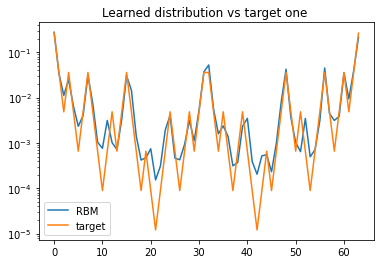

In [25]:
rbm = RBM(n_vis=6, n_hid=6)
rbm.load_state_dict(torch.load("trained_rbm.pytorch.last"))
# Exact RBM partitional function
Zrbm = 0
for i in range(64):
    Zrbm = Zrbm+ exp(rbm.free_energy(states[i]))
  
# Build distribution
x = [0 for i in range(64)]
y = [0 for i in range(64)]
z = [0 for i in range(64)]
Y = [0 for i in range(64)]
Z = [0 for i in range(64)]
d = [0 for i in range(64)]

for i in range(64):
    x[i] = i
    y[i] = P_rbm(states[i], rbm)
    Y[i] = p(states[i])


Zising = 2*pow(exp(1)+exp(-1),5)

# Plot results
plt.semilogy(x,y,label="RBM")
plt.semilogy(x,Y, label="target")
plt.title("Learned distribution vs target one ")
plt.legend()
plt.show()